# 21. 特徴量重要度の深掘り - 4つのアプローチで本質を見抜く

## 概要

「この特徴量は重要だ」という言葉の意味は、**測定方法によって全く異なります**。

本ノートブックでは、タイタニックデータセットを使って4つの異なるアプローチで特徴量重要度を分析し、
**各手法が何を測っているのか**を深く理解します。

## 4つのアプローチ

| 手法 | 測定対象 | 哲学 |
|------|----------|------|
| **相互情報量 (MI)** | データの結びつきの強さ | 統計的な依存関係 |
| **Permutation Importance** | その情報の必要不可欠さ | 破壊的検証 |
| **LIME** | 局所的な影響 | 線形近似による説明 |
| **SHAP** | 予測値への具体的な加担量 | ゲーム理論的公平性 |

## 学習目標

- 各手法の**数学的背景と直感的意味**を理解する
- タイタニックデータで**実際に計算・可視化**する
- 手法間の**結果の違いを解釈**できるようになる
- **適切な手法を選択**できるようになる

---

## Part 0: なぜ複数の手法が必要なのか？

### 「重要度」の多義性

考えてみてください：「性別はタイタニックの生存予測に重要」という主張には、複数の解釈があります。

1. **統計的解釈**: 性別と生存には強い相関がある（女性74%生存 vs 男性19%生存）
2. **モデル依存的解釈**: モデルから性別情報を取り除くと、予測精度が大きく下がる
3. **個別予測の解釈**: この乗客が生存と予測された理由の何%が性別によるものか

これらは**異なる質問**であり、**異なる答え**が返ってきます。

### 各手法の位置づけ

```
                    モデル非依存 ←――――――――――→ モデル依存
                         |
    相互情報量 (MI)      |    Permutation Importance
    「データに何がある？」|    「モデルは何を使っている？」
                         |
    ─────────────────────┼─────────────────────────────
                         |
    LIME                 |    SHAP
    「この予測を        |    「この予測への
    　単純に説明すると？」|    　公平な貢献度は？」
                         |
                    グローバル ←――――――――――→ ローカル
```

---

In [1]:
# ============================================================
# ライブラリのインポート
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# SHAP
import shap
shap.initjs()

# LIME
try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except ImportError:
    print("LIME is not installed. Run: pip install lime")
    LIME_AVAILABLE = False

# 設定
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_style('whitegrid')
np.random.seed(42)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic',
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
print(f"Japanese font: {font_used}")
print("Libraries loaded successfully!")

Japanese font: Hiragino Sans
Libraries loaded successfully!


---

## Part 1: タイタニックデータの準備

まず、分析に使うデータを準備します。Notebook 15で学んだ特徴量エンジニアリングを適用します。

In [2]:
# ============================================================
# タイタニックデータの読み込みと前処理
# ============================================================

# データ読み込み
df = sns.load_dataset('titanic')
print(f"Original shape: {df.shape}")

# 前処理
df_clean = df.copy()

# 1. 欠損値の補完（グループごとの中央値）
for sex in ['male', 'female']:
    for pclass in [1, 2, 3]:
        mask = (df_clean['sex'] == sex) & (df_clean['pclass'] == pclass) & (df_clean['age'].isnull())
        group_median = df_clean[(df_clean['sex'] == sex) & (df_clean['pclass'] == pclass)]['age'].median()
        df_clean.loc[mask, 'age'] = group_median

# 2. embarkedの欠損を最頻値で補完
df_clean['embarked'].fillna(df_clean['embarked'].mode()[0], inplace=True)

# 3. 特徴量エンジニアリング
df_clean['family_size'] = df_clean['sibsp'] + df_clean['parch'] + 1
df_clean['is_alone'] = (df_clean['family_size'] == 1).astype(int)
df_clean['has_cabin'] = df_clean['deck'].notnull().astype(int)

# 4. Titleの作成
def create_title(row):
    if row['sex'] == 'female':
        if row['age'] < 18:
            return 'Miss'
        else:
            return 'Mrs' if row['parch'] > 0 or row['sibsp'] > 0 else 'Miss'
    else:
        if row['age'] < 18:
            return 'Master'
        else:
            return 'Mr'

df_clean['title'] = df_clean.apply(create_title, axis=1)

# 5. 年齢カテゴリ
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 12, 18, 35, 60, 100], 
                                labels=['Child', 'Teen', 'Young', 'Adult', 'Senior'])

# 6. 運賃カテゴリ（対数変換後）
df_clean['fare_log'] = np.log1p(df_clean['fare'])

print(f"\nAfter feature engineering: {df_clean.shape}")
df_clean.head()

Original shape: (891, 15)

After feature engineering: (891, 21)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,...,deck,embark_town,alive,alone,family_size,is_alone,has_cabin,title,age_group,fare_log
0,0,3,male,22.0,1,0,7.2500,S,Third,man,...,NaN,Southampton,no,False,2,0,0,Mr,Young,2.110213
1,1,1,female,38.0,1,0,71.2833,C,First,woman,...,C,Cherbourg,yes,False,2,0,1,Mrs,Adult,4.280593
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,...,NaN,Southampton,yes,True,1,1,0,Miss,Young,2.188856
3,1,1,female,35.0,1,0,53.1000,S,First,woman,...,C,Southampton,yes,False,2,0,1,Mrs,Young,3.990834
4,0,3,male,35.0,0,0,8.0500,S,Third,man,...,NaN,Southampton,no,True,1,1,0,Mr,Young,2.202765


In [3]:
# ============================================================
# モデル用の特徴量を選択・エンコード
# ============================================================

# 使用する特徴量（解釈しやすいものを選択）
feature_cols = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked',
                'family_size', 'is_alone', 'has_cabin', 'title']

# カテゴリ変数のエンコード
df_model = df_clean[feature_cols + ['survived']].copy()

# Label Encoding
label_encoders = {}
categorical_cols = ['sex', 'embarked', 'title']

for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 特徴量と目的変数の分離
X = df_model[feature_cols]
y = df_model['survived']

# 訓練・テスト分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nFeatures: {feature_cols}")

sex: {'female': np.int64(0), 'male': np.int64(1)}
embarked: {'C': np.int64(0), 'Q': np.int64(1), 'S': np.int64(2)}
title: {'Master': np.int64(0), 'Miss': np.int64(1), 'Mr': np.int64(2), 'Mrs': np.int64(3)}

Training set: (712, 11)
Test set: (179, 11)

Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'family_size', 'is_alone', 'has_cabin', 'title']


In [4]:
# ============================================================
# ベースモデルの訓練
# ============================================================

# Random Forest（メインモデル）
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Gradient Boosting（比較用）
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train, y_train)

# 性能評価
print("Model Performance:")
print("="*50)
print(f"Random Forest - Train: {rf_model.score(X_train, y_train):.4f}, Test: {rf_model.score(X_test, y_test):.4f}")
print(f"Gradient Boosting - Train: {gb_model.score(X_train, y_train):.4f}, Test: {gb_model.score(X_test, y_test):.4f}")

Model Performance:
Random Forest - Train: 0.9565, Test: 0.7989
Gradient Boosting - Train: 0.9635, Test: 0.8045


---

## Part 2: 相互情報量 (Mutual Information)

### 概念

相互情報量（MI）は、**2つの変数間の統計的依存関係の強さ**を測る指標です。

### 数学的定義

$$I(X; Y) = \sum_{x, y} p(x, y) \log \frac{p(x, y)}{p(x) p(y)}$$

### 直感的理解

- **MI = 0**: X と Y は完全に独立（Xを知ってもYについて何も分からない）
- **MI > 0**: X と Y には依存関係がある（Xを知るとYについて何か分かる）
- **MI が大きい**: X と Y の結びつきが強い

### 特徴

| 長所 | 短所 |
|------|------|
| モデルに依存しない | 特徴量間の相互作用は考慮しない |
| 非線形な関係も検出できる | 連続変数の離散化が必要な場合がある |
| 計算が高速 | 単変量解析（1つずつ評価） |

### 「重要度」の意味

**「この特徴量とターゲットの間にどれだけ情報的な結びつきがあるか」**

→ モデルを使う前に、データ自体にどれだけ予測に使える情報があるかを知る

In [5]:
# ============================================================
# 相互情報量の計算
# ============================================================

# sklearn の mutual_info_classif を使用
# discrete_features: カテゴリ変数かどうかを指定
discrete_mask = [True, True, False, True, True, False, True, True, True, True, True]
# pclass, sex, age, sibsp, parch, fare, embarked, family_size, is_alone, has_cabin, title

mi_scores = mutual_info_classif(
    X_train, y_train, 
    discrete_features=discrete_mask,
    random_state=42
)

# 結果をDataFrameに整理
mi_df = pd.DataFrame({
    'Feature': feature_cols,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("Mutual Information Scores:")
print("="*50)
print(mi_df.to_string(index=False))

Mutual Information Scores:
    Feature  MI_Score
       fare  0.168456
      title  0.164443
        sex  0.154343
        age  0.069821
  has_cabin  0.061673
     pclass  0.060769
family_size  0.053603
      sibsp  0.024521
   is_alone  0.023125
      parch  0.018701
   embarked  0.017502


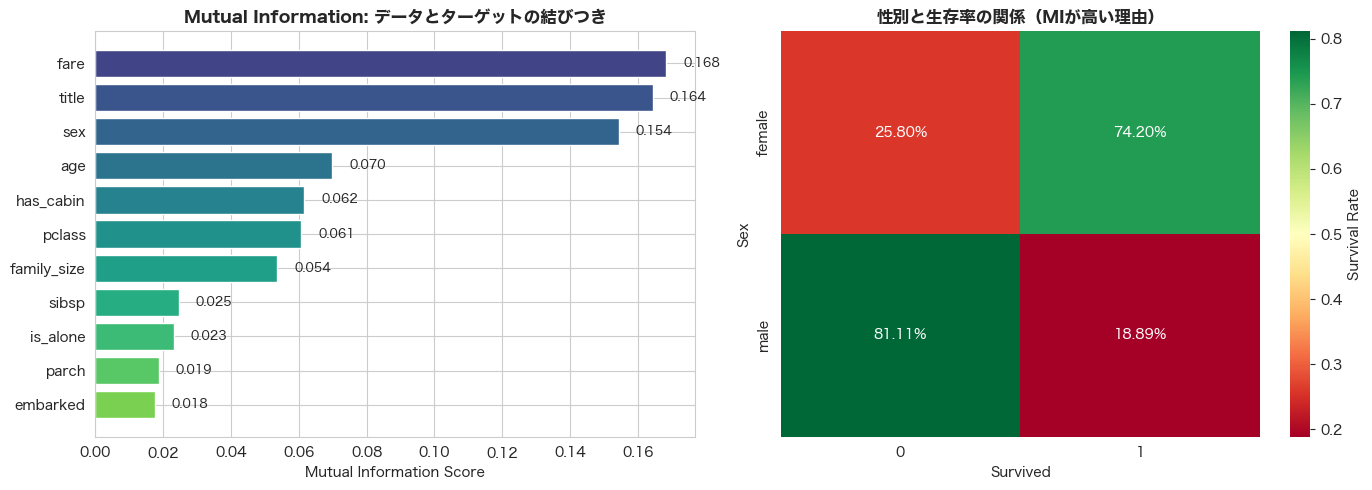


解釈:
- 'sex'のMIが最も高い → 性別と生存には強い統計的依存関係がある
- 'title'も高い → 敬称には性別・年齢・家族情報が含まれている
- 'sibsp'が低い → 単独では生存との関連が弱い（family_sizeの一部として見ると意味がある）


In [6]:
# ============================================================
# 相互情報量の可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 棒グラフ
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(mi_df)))
ax1 = axes[0]
bars = ax1.barh(mi_df['Feature'], mi_df['MI_Score'], color=colors)
ax1.set_xlabel('Mutual Information Score')
ax1.set_title('Mutual Information: データとターゲットの結びつき', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# 値を表示
for bar, score in zip(bars, mi_df['MI_Score']):
    ax1.text(score + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{score:.3f}', va='center', fontsize=9)

# 解釈用のヒートマップ（性別とpclassの例）
ax2 = axes[1]
cross_tab = pd.crosstab(df_clean['sex'], df_clean['survived'], normalize='index')
sns.heatmap(cross_tab, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax2, cbar_kws={'label': 'Survival Rate'})
ax2.set_title('性別と生存率の関係（MIが高い理由）', fontsize=12, fontweight='bold')
ax2.set_ylabel('Sex')
ax2.set_xlabel('Survived')

plt.tight_layout()
plt.show()

print("\n解釈:")
print("- 'sex'のMIが最も高い → 性別と生存には強い統計的依存関係がある")
print("- 'title'も高い → 敬称には性別・年齢・家族情報が含まれている")
print("- 'sibsp'が低い → 単独では生存との関連が弱い（family_sizeの一部として見ると意味がある）")

### 相互情報量の限界を理解する

MIは**単変量解析**であり、特徴量間の相互作用を考慮しません。

例えば、`sibsp`と`parch`は個別には弱い関連でも、`family_size`として組み合わせると重要になります。

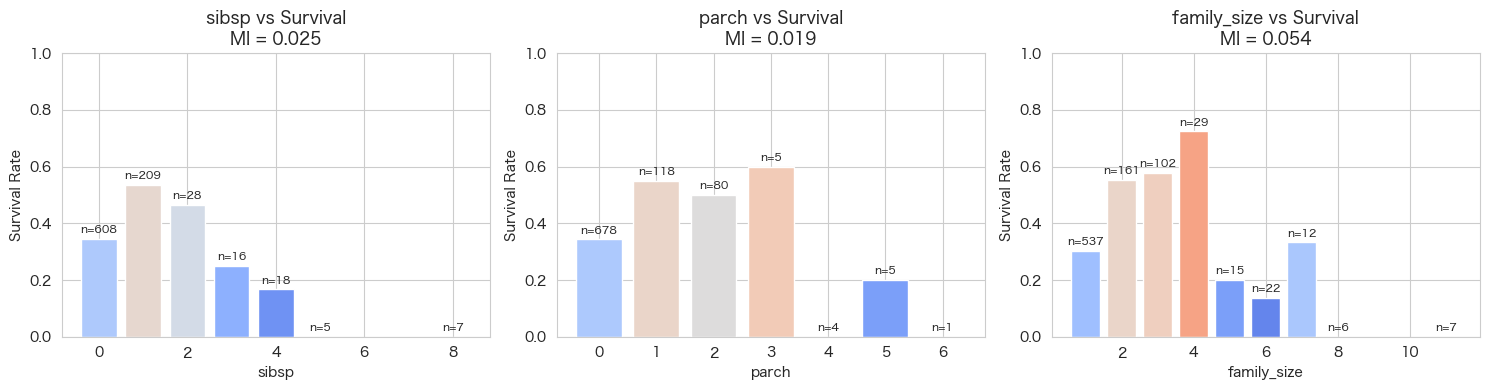


観察:
- sibsp/parchは個別には生存率との関係が複雑
- family_sizeとして統合すると、明確なパターン（2-4人が有利）が見える
- これがMIの限界：複合的な関係は捉えられない


In [7]:
# ============================================================
# MIの限界：相互作用の見落とし
# ============================================================

# sibsp, parch, family_sizeの比較
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, col in zip(axes, ['sibsp', 'parch', 'family_size']):
    survival_by_col = df_clean.groupby(col)['survived'].mean()
    counts = df_clean.groupby(col).size()
    
    bars = ax.bar(survival_by_col.index, survival_by_col.values, 
                  color=plt.cm.coolwarm(survival_by_col.values))
    ax.set_xlabel(col)
    ax.set_ylabel('Survival Rate')
    ax.set_title(f'{col} vs Survival\nMI = {mi_df[mi_df["Feature"]==col]["MI_Score"].values[0]:.3f}')
    ax.set_ylim(0, 1)
    
    # サンプル数を表示
    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'n={count}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("\n観察:")
print("- sibsp/parchは個別には生存率との関係が複雑")
print("- family_sizeとして統合すると、明確なパターン（2-4人が有利）が見える")
print("- これがMIの限界：複合的な関係は捉えられない")

---

## Part 3: Permutation Importance（順列重要度）

### 概念

Permutation Importanceは、**特徴量の値をシャッフルした時に予測性能がどれだけ低下するか**を測ります。

### アルゴリズム

1. ベースラインの予測性能（精度など）を計算
2. 特徴量 $X_j$ の値をランダムにシャッフル（順序を壊す）
3. シャッフル後のデータで予測性能を計算
4. 性能の低下量 = 重要度
5. 各特徴量について繰り返す

### 直感的理解

**「この特徴量の情報を壊したら、モデルはどれだけ困るか？」**

- 重要度が高い → その特徴量がないと予測できない
- 重要度が低い → その特徴量がなくても大丈夫

### 特徴

| 長所 | 短所 |
|------|------|
| モデルに依存しない（どのモデルにも適用可） | 相関の高い特徴量があると過小評価される |
| 訓練済みモデルで計算できる | 計算コストが高い（特徴量数×繰り返し回数） |
| テストデータでの真の重要度がわかる | シャッフルの回数でばらつく |

### 「重要度」の意味

**「このモデルにとって、この特徴量がどれだけ必要不可欠か」**

In [8]:
# ============================================================
# Permutation Importance の計算
# ============================================================

# テストデータでの Permutation Importance
perm_importance_test = permutation_importance(
    rf_model, X_test, y_test,
    n_repeats=30,  # シャッフル回数
    random_state=42,
    n_jobs=-1
)

# 訓練データでの Permutation Importance（比較用）
perm_importance_train = permutation_importance(
    rf_model, X_train, y_train,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# 結果をDataFrameに整理
perm_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance_Test': perm_importance_test.importances_mean,
    'Std_Test': perm_importance_test.importances_std,
    'Importance_Train': perm_importance_train.importances_mean,
    'Std_Train': perm_importance_train.importances_std
}).sort_values('Importance_Test', ascending=False)

print("Permutation Importance (Test Data):")
print("="*60)
print(perm_df[['Feature', 'Importance_Test', 'Std_Test']].to_string(index=False))

Permutation Importance (Test Data):
    Feature  Importance_Test  Std_Test
        sex         0.129981  0.025517
        age         0.028864  0.013842
      title         0.023091  0.013041
     pclass         0.017877  0.011665
       fare         0.017318  0.018379
family_size         0.016387  0.009115
   embarked         0.011173  0.011080
      parch         0.005587  0.005587
  has_cabin         0.003724  0.014663
   is_alone        -0.006331  0.008253
      sibsp        -0.014898  0.007541


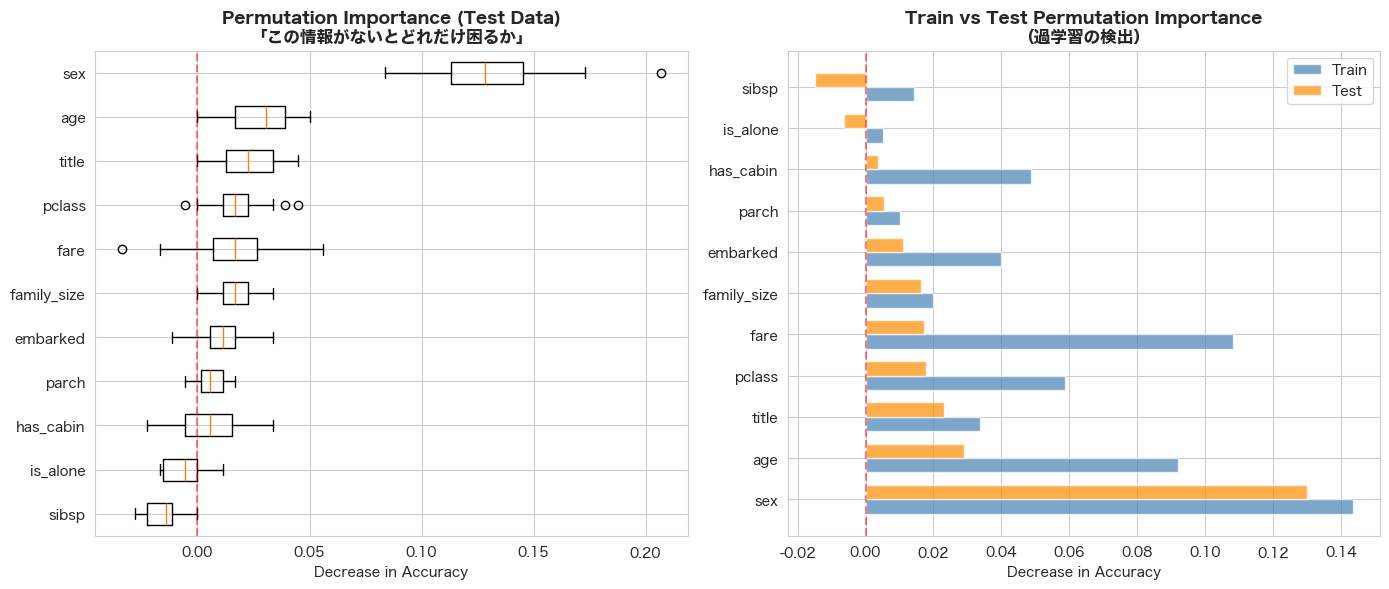


解釈:
- 'sex'が最も重要 → この情報がないと予測精度が大きく下がる
- Train > Test の場合、その特徴量に過学習している可能性
- 負の値 → シャッフルしても精度が下がらない（または上がる）= 重要でない


In [9]:
# ============================================================
# Permutation Importance の可視化
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# テストデータでの重要度（エラーバー付き）
ax1 = axes[0]
sorted_idx = perm_importance_test.importances_mean.argsort()
ax1.boxplot(perm_importance_test.importances[sorted_idx].T, vert=False,
            labels=np.array(feature_cols)[sorted_idx])
ax1.set_xlabel('Decrease in Accuracy')
ax1.set_title('Permutation Importance (Test Data)\n「この情報がないとどれだけ困るか」', 
              fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# 訓練 vs テストの比較
ax2 = axes[1]
x = np.arange(len(feature_cols))
width = 0.35

bars1 = ax2.barh(x - width/2, perm_df['Importance_Train'], width, 
                 label='Train', color='steelblue', alpha=0.7)
bars2 = ax2.barh(x + width/2, perm_df['Importance_Test'], width, 
                 label='Test', color='darkorange', alpha=0.7)

ax2.set_yticks(x)
ax2.set_yticklabels(perm_df['Feature'])
ax2.set_xlabel('Decrease in Accuracy')
ax2.set_title('Train vs Test Permutation Importance\n（過学習の検出）', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print("\n解釈:")
print("- 'sex'が最も重要 → この情報がないと予測精度が大きく下がる")
print("- Train > Test の場合、その特徴量に過学習している可能性")
print("- 負の値 → シャッフルしても精度が下がらない（または上がる）= 重要でない")

### Permutation Importance の注意点：多重共線性

相関の高い特徴量があると、一方をシャッフルしてももう一方から情報を得られるため、重要度が過小評価されます。

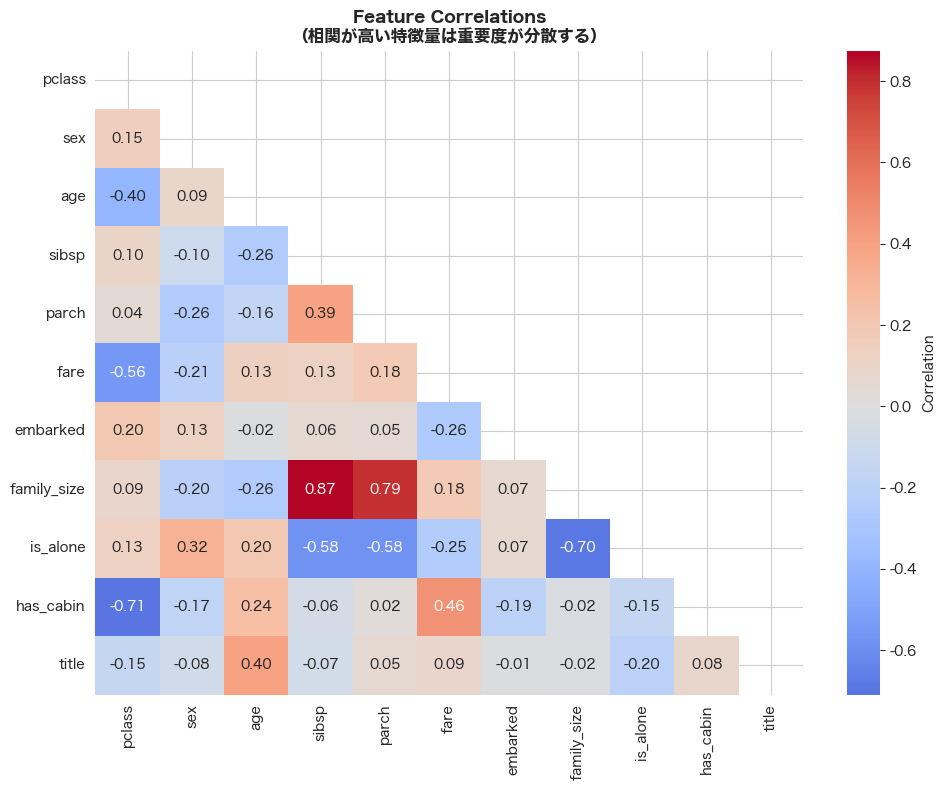


注目すべき相関:
- pclass と fare: -0.56（高いクラスほど高い運賃）
- sibsp/parch と family_size: 高相関（family_size = sibsp + parch + 1）
- is_alone と family_size: -0.52（一人なら family_size=1）

これらの相関により、Permutation Importance は重要度を分散させる


In [10]:
# ============================================================
# 特徴量間の相関を確認
# ============================================================

fig, ax = plt.subplots(figsize=(10, 8))

corr_matrix = X_train.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, ax=ax,
            cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlations\n（相関が高い特徴量は重要度が分散する）', 
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n注目すべき相関:")
print("- pclass と fare: -0.56（高いクラスほど高い運賃）")
print("- sibsp/parch と family_size: 高相関（family_size = sibsp + parch + 1）")
print("- is_alone と family_size: -0.52（一人なら family_size=1）")
print("\nこれらの相関により、Permutation Importance は重要度を分散させる")

---

## Part 4: LIME (Local Interpretable Model-agnostic Explanations)

### 概念

LIMEは、**複雑なモデルの個別予測を、局所的な線形モデルで近似して説明**します。

### アルゴリズム

1. 説明したいサンプル $x$ の周りに、摂動（ノイズを加えた）サンプルを生成
2. 各摂動サンプルに対するモデルの予測を取得
3. $x$ からの距離で重み付けした線形モデルを学習
4. 線形モデルの係数 = 各特徴量の局所的な影響

### 直感的理解

**「この予測を、シンプルな線形モデルで説明するとどうなるか？」**

例：「この乗客が生存と予測されたのは、女性（+0.4）で1等（+0.2）だから」

### 特徴

| 長所 | 短所 |
|------|------|
| モデルに依存しない | 局所的な説明のみ（グローバルには適さない） |
| 人間が理解しやすい線形の説明 | 摂動サンプルの生成方法に依存 |
| 個別予測の「なぜ」を説明できる | 安定性が低い（同じサンプルでも結果が変わることがある） |

### 「重要度」の意味

**「この特定の予測に対して、各特徴量がどの方向にどれだけ影響したか」**（局所的）

In [11]:
# ============================================================
# LIME Explainer の作成
# ============================================================

if LIME_AVAILABLE:
    # LIMEのexplainerを作成
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_cols,
        class_names=['Died', 'Survived'],
        mode='classification',
        discretize_continuous=True,
        random_state=42
    )
    print("LIME Explainer created successfully!")
else:
    print("LIME is not available. Please install it with: pip install lime")

LIME Explainer created successfully!


In [12]:
# ============================================================
# 個別予測の説明 (LIME)
# ============================================================

if LIME_AVAILABLE:
    # 興味深いサンプルを選択
    # 1. 生存した女性（典型的なケース）
    # 2. 死亡した男性（典型的なケース）
    # 3. 生存した男性（珍しいケース）
    
    # テストデータから特定のパターンを探す
    test_with_pred = X_test.copy()
    test_with_pred['actual'] = y_test.values
    test_with_pred['predicted'] = rf_model.predict(X_test)
    test_with_pred['proba'] = rf_model.predict_proba(X_test)[:, 1]
    
    # サンプル選択
    # 女性で生存（高確率）
    female_survived_idx = test_with_pred[(test_with_pred['sex'] == 0) & 
                                          (test_with_pred['actual'] == 1)].index[0]
    # 男性で死亡（典型的）
    male_died_idx = test_with_pred[(test_with_pred['sex'] == 1) & 
                                    (test_with_pred['actual'] == 0)].index[0]
    # 男性で生存（珍しい）
    male_survived = test_with_pred[(test_with_pred['sex'] == 1) & 
                                    (test_with_pred['actual'] == 1)]
    male_survived_idx = male_survived.index[0] if len(male_survived) > 0 else male_died_idx
    
    sample_indices = [female_survived_idx, male_died_idx, male_survived_idx]
    sample_names = ['Female Survived', 'Male Died', 'Male Survived']
    
    print("Selected samples for LIME explanation:")
    print("="*60)
    for idx, name in zip(sample_indices, sample_names):
        proba = rf_model.predict_proba(X_test.loc[[idx]])[0]
        print(f"\n{name} (Index: {idx}):")
        print(f"  Prediction: {'Survived' if proba[1] > 0.5 else 'Died'} (P={proba[1]:.3f})")
        print(f"  Features: {dict(X_test.loc[idx])}")

Selected samples for LIME explanation:

Female Survived (Index: 241):
  Prediction: Survived (P=0.678)
  Features: {'pclass': np.float64(3.0), 'sex': np.float64(0.0), 'age': np.float64(21.5), 'sibsp': np.float64(1.0), 'parch': np.float64(0.0), 'fare': np.float64(15.5), 'embarked': np.float64(1.0), 'family_size': np.float64(2.0), 'is_alone': np.float64(0.0), 'has_cabin': np.float64(0.0), 'title': np.float64(3.0)}

Male Died (Index: 565):
  Prediction: Died (P=0.156)
  Features: {'pclass': np.float64(3.0), 'sex': np.float64(1.0), 'age': np.float64(24.0), 'sibsp': np.float64(2.0), 'parch': np.float64(0.0), 'fare': np.float64(24.15), 'embarked': np.float64(2.0), 'family_size': np.float64(3.0), 'is_alone': np.float64(0.0), 'has_cabin': np.float64(0.0), 'title': np.float64(2.0)}

Male Survived (Index: 553):
  Prediction: Died (P=0.128)
  Features: {'pclass': np.float64(3.0), 'sex': np.float64(1.0), 'age': np.float64(22.0), 'sibsp': np.float64(0.0), 'parch': np.float64(0.0), 'fare': np.float6

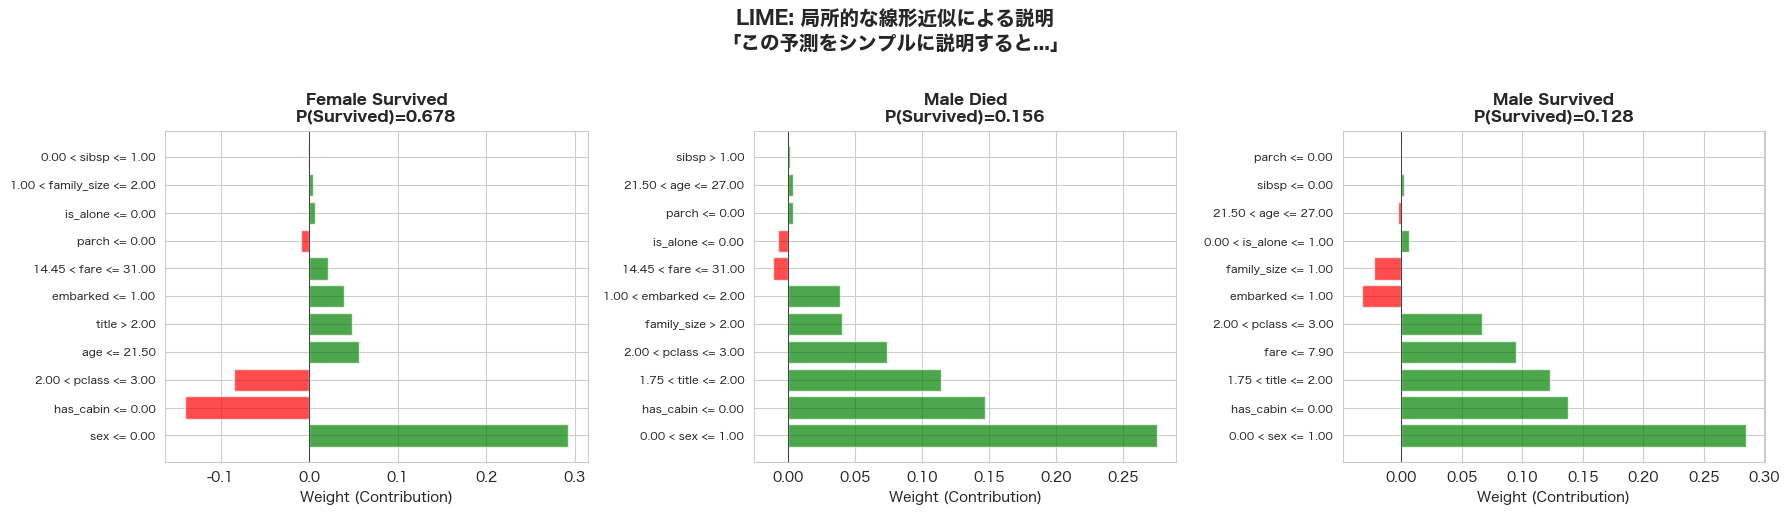


解釈:
- 緑: 生存確率を上げる要因
- 赤: 生存確率を下げる要因
- Female Survived: 'sex <= 0.50' が大きく貢献（女性であること）
- Male Died: 'sex > 0.50' が大きなマイナス（男性であること）
- Male Survived: 他の要因（pclass, ageなど）が性別のマイナスを補っている


In [13]:
# ============================================================
# LIME による個別説明の可視化
# ============================================================

if LIME_AVAILABLE:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for ax, idx, name in zip(axes, sample_indices, sample_names):
        # LIME説明を生成
        exp = lime_explainer.explain_instance(
            X_test.loc[idx].values,
            rf_model.predict_proba,
            num_features=len(feature_cols),
            top_labels=1
        )
        
        # 予測クラス
        predicted_class = 1 if rf_model.predict_proba(X_test.loc[[idx]])[0][1] > 0.5 else 0
        
        # 説明を取得
        exp_list = exp.as_list(label=predicted_class)
        features = [e[0] for e in exp_list]
        weights = [e[1] for e in exp_list]
        
        # 棒グラフ
        colors = ['green' if w > 0 else 'red' for w in weights]
        y_pos = np.arange(len(features))
        ax.barh(y_pos, weights, color=colors, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(features, fontsize=8)
        ax.set_xlabel('Weight (Contribution)')
        ax.set_title(f'{name}\nP(Survived)={rf_model.predict_proba(X_test.loc[[idx]])[0][1]:.3f}', 
                     fontsize=11, fontweight='bold')
        ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    
    plt.suptitle('LIME: 局所的な線形近似による説明\n「この予測をシンプルに説明すると...」', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n解釈:")
    print("- 緑: 生存確率を上げる要因")
    print("- 赤: 生存確率を下げる要因")
    print("- Female Survived: 'sex <= 0.50' が大きく貢献（女性であること）")
    print("- Male Died: 'sex > 0.50' が大きなマイナス（男性であること）")
    print("- Male Survived: 他の要因（pclass, ageなど）が性別のマイナスを補っている")

### LIMEの安定性を検証

LIMEは摂動サンプルの生成にランダム性があるため、同じサンプルでも異なる説明が得られることがあります。

In [14]:
# ============================================================
# LIMEの安定性検証
# ============================================================

if LIME_AVAILABLE:
    # 同じサンプルに対して複数回LIMEを実行
    sample_idx = female_survived_idx
    n_runs = 5
    
    all_weights = {feat: [] for feat in feature_cols}
    
    for run in range(n_runs):
        exp = lime_explainer.explain_instance(
            X_test.loc[sample_idx].values,
            rf_model.predict_proba,
            num_features=len(feature_cols)
        )
        
        exp_dict = dict(exp.as_list())
        for feat in feature_cols:
            # 特徴量名を含むキーを探す
            weight = 0
            for key, val in exp_dict.items():
                if feat in key:
                    weight = val
                    break
            all_weights[feat].append(weight)
    
    # 結果を表示
    print("LIME Stability Check (5 runs on the same sample):")
    print("="*60)
    print(f"{'Feature':<15} {'Mean':>10} {'Std':>10} {'CV%':>10}")
    print("-"*60)
    for feat in feature_cols:
        weights = all_weights[feat]
        mean_w = np.mean(weights)
        std_w = np.std(weights)
        cv = (std_w / abs(mean_w) * 100) if mean_w != 0 else 0
        print(f"{feat:<15} {mean_w:>10.4f} {std_w:>10.4f} {cv:>10.1f}")
    
    print("\n注意: CV（変動係数）が高い特徴量は、説明が不安定")

LIME Stability Check (5 runs on the same sample):
Feature               Mean        Std        CV%
------------------------------------------------------------
pclass             -0.0821     0.0040        4.9
sex                 0.2807     0.0029        1.0
age                 0.0602     0.0033        5.5
sibsp               0.0025     0.0059      233.0
parch              -0.0083     0.0035       42.9
fare                0.0136     0.0040       29.2
embarked            0.0376     0.0053       14.0
family_size         0.0017     0.0022      131.5
is_alone            0.0037     0.0075      202.3
has_cabin          -0.1343     0.0030        2.2
title               0.0479     0.0024        5.1

注意: CV（変動係数）が高い特徴量は、説明が不安定


---

## Part 5: SHAP (SHapley Additive exPlanations)

### 概念

SHAPは、ゲーム理論の**Shapley値**に基づいて、各特徴量の予測への貢献度を公平に計算します。

### Shapley値の考え方

「各プレイヤー（特徴量）が、チームの成果（予測）にどれだけ貢献したか」を公平に分配する方法。

$$\phi_j = \sum_{S \subseteq N \setminus \{j\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} [f(S \cup \{j\}) - f(S)]$$

### 直感的理解

**「この特徴量が参加したことで、予測がどれだけ変わったか」**（全ての参加順序を考慮）

例：性別が「女性」の場合、ベースライン予測（38%生存）から最終予測（74%生存）への変化のうち、
どれだけが性別によるものか、他の特徴量との組み合わせを全て考慮して計算。

### 特徴

| 長所 | 短所 |
|------|------|
| 理論的に公平な分配 | 計算コストが高い（厳密計算は指数的） |
| グローバル＆ローカル両方の解釈が可能 | 近似アルゴリズムに依存 |
| 一貫性のある説明 | 相関のある特徴量の扱いが難しい |

### 「重要度」の意味

**「予測値への実際の貢献度（金額に例えると、いくら払うべきか）」**

In [15]:
# ============================================================
# SHAP値の計算
# ============================================================

# TreeExplainer（ツリーベースモデル用の高速explainer）
shap_explainer = shap.TreeExplainer(rf_model)

# テストデータのSHAP値を計算
shap_values = shap_explainer.shap_values(X_test)

# 形状の確認と処理
if isinstance(shap_values, list):
    # 古いバージョン: リスト形式 [class0, class1]
    shap_values_class1 = shap_values[1]
elif len(shap_values.shape) == 3:
    # 新しいバージョン: (n_samples, n_features, n_classes)
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

print(f"SHAP values shape: {shap_values_class1.shape}")
print(f"Expected value (base): {shap_explainer.expected_value}")

SHAP values shape: (179, 11)
Expected value (base): [0.615 0.385]


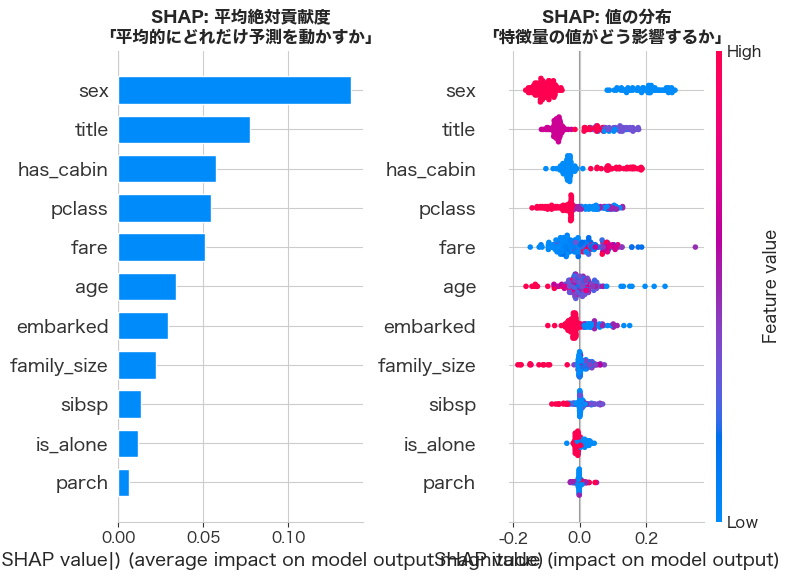


Beeswarm Plot の読み方:
- 各点が1つのサンプル
- 色: 特徴量の値（赤=高、青=低）
- X軸: SHAP値（正=生存確率↑、負=生存確率↓）

観察:
- sex: 青（女性=0）が右（生存↑）、赤（男性=1）が左（生存↓）
- pclass: 青（1等=低い値）が右（生存↑）
- age: 青（若い）が右（生存↑）傾向


In [16]:
# ============================================================
# SHAP Summary Plot（グローバル重要度）
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot（平均絶対SHAP値）
plt.sca(axes[0])
shap.summary_plot(shap_values_class1, X_test, plot_type="bar", show=False, 
                  feature_names=feature_cols)
axes[0].set_title('SHAP: 平均絶対貢献度\n「平均的にどれだけ予測を動かすか」', 
                  fontsize=12, fontweight='bold')

# Beeswarm plot（値の分布）
plt.sca(axes[1])
shap.summary_plot(shap_values_class1, X_test, show=False, 
                  feature_names=feature_cols)
axes[1].set_title('SHAP: 値の分布\n「特徴量の値がどう影響するか」', 
                  fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nBeeswarm Plot の読み方:")
print("- 各点が1つのサンプル")
print("- 色: 特徴量の値（赤=高、青=低）")
print("- X軸: SHAP値（正=生存確率↑、負=生存確率↓）")
print("\n観察:")
print("- sex: 青（女性=0）が右（生存↑）、赤（男性=1）が左（生存↓）")
print("- pclass: 青（1等=低い値）が右（生存↑）")
print("- age: 青（若い）が右（生存↑）傾向")

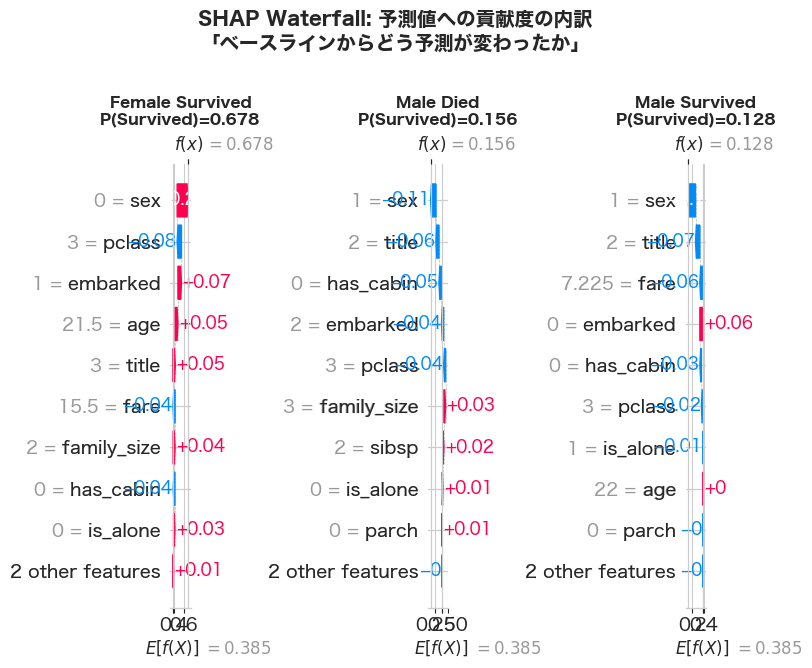


Waterfall Plot の読み方:
- E[f(x)]: ベースライン（全サンプルの平均予測）
- 赤: 予測を増加させる要因
- 青: 予測を減少させる要因
- f(x): 最終的な予測値


In [17]:
# ============================================================
# SHAP Waterfall Plot（個別予測の説明）
# ============================================================

# 先ほどと同じサンプルで比較
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

expected_val = shap_explainer.expected_value
if isinstance(expected_val, (list, np.ndarray)):
    expected_val = expected_val[1]

for i, (idx, name) in enumerate(zip(sample_indices, sample_names)):
    # インデックスをX_testの位置に変換
    pos = X_test.index.get_loc(idx)
    
    plt.sca(axes[i])
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_class1[pos],
            base_values=expected_val,
            data=X_test.iloc[pos].values,
            feature_names=feature_cols
        ),
        show=False
    )
    axes[i].set_title(f'{name}\nP(Survived)={rf_model.predict_proba(X_test.loc[[idx]])[0][1]:.3f}', 
                      fontsize=11, fontweight='bold')

plt.suptitle('SHAP Waterfall: 予測値への貢献度の内訳\n「ベースラインからどう予測が変わったか」', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nWaterfall Plot の読み方:")
print("- E[f(x)]: ベースライン（全サンプルの平均予測）")
print("- 赤: 予測を増加させる要因")
print("- 青: 予測を減少させる要因")
print("- f(x): 最終的な予測値")

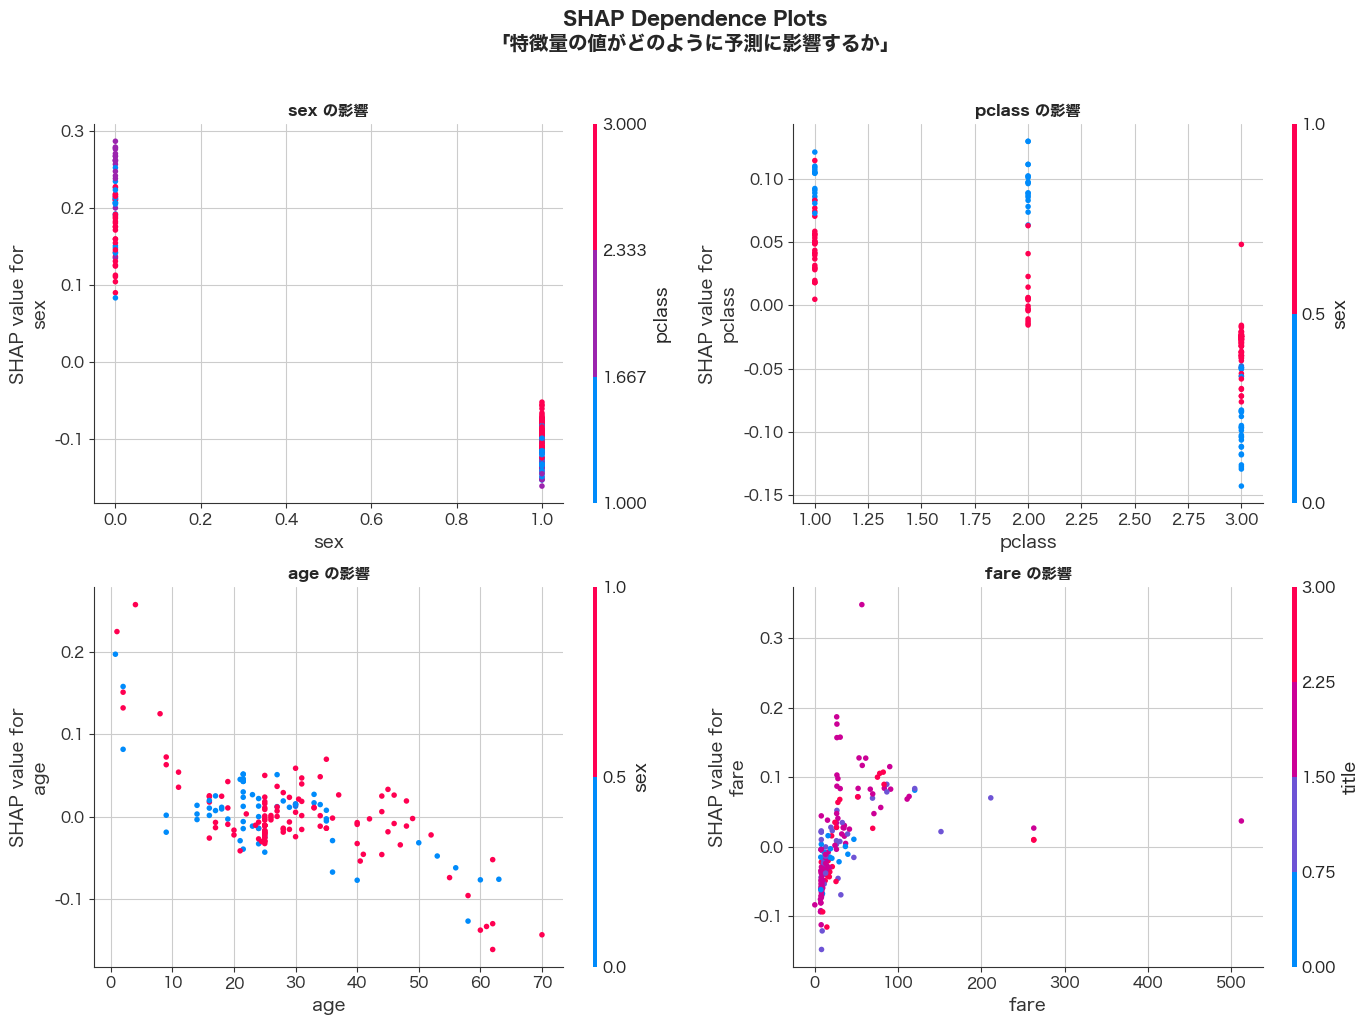


観察:
- sex: 0（女性）→ 正のSHAP値、1（男性）→ 負のSHAP値（明確な分離）
- pclass: 1等 → 正、3等 → 負（階級による格差）
- age: 若いほど正の傾向（子供優先）
- fare: 高いほど正の傾向（高額チケット=上級客室）


In [18]:
# ============================================================
# SHAP Dependence Plot（特徴量と予測の関係）
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

important_features = ['sex', 'pclass', 'age', 'fare']

for ax, feat in zip(axes.flatten(), important_features):
    plt.sca(ax)
    shap.dependence_plot(
        feat,
        shap_values_class1,
        X_test,
        feature_names=feature_cols,
        show=False,
        ax=ax
    )
    ax.set_title(f'{feat} の影響', fontsize=11, fontweight='bold')

plt.suptitle('SHAP Dependence Plots\n「特徴量の値がどのように予測に影響するか」', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n観察:")
print("- sex: 0（女性）→ 正のSHAP値、1（男性）→ 負のSHAP値（明確な分離）")
print("- pclass: 1等 → 正、3等 → 負（階級による格差）")
print("- age: 若いほど正の傾向（子供優先）")
print("- fare: 高いほど正の傾向（高額チケット=上級客室）")

---

## Part 6: 4つの手法の比較

各手法で計算した「重要度」を比較し、その違いを理解します。

In [19]:
# ============================================================
# 全手法の重要度を統合
# ============================================================

# 各手法の重要度を正規化（0-1スケール）
def normalize(x):
    x = np.array(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-10)

# Random Forestの組み込み重要度（参考）
rf_importance = rf_model.feature_importances_

# SHAP重要度（平均絶対値）
shap_importance = np.abs(shap_values_class1).mean(axis=0)

# 統合DataFrame
comparison_df = pd.DataFrame({
    'Feature': feature_cols,
    'MI': mi_scores,
    'Permutation': perm_importance_test.importances_mean,
    'SHAP': shap_importance,
    'RF_Builtin': rf_importance
})

# 正規化
for col in ['MI', 'Permutation', 'SHAP', 'RF_Builtin']:
    comparison_df[f'{col}_norm'] = normalize(comparison_df[col])

# ランキング
for col in ['MI', 'Permutation', 'SHAP', 'RF_Builtin']:
    comparison_df[f'{col}_rank'] = comparison_df[col].rank(ascending=False)

print("Feature Importance Comparison (Raw Values):")
print("="*80)
print(comparison_df[['Feature', 'MI', 'Permutation', 'SHAP', 'RF_Builtin']].to_string(index=False))

Feature Importance Comparison (Raw Values):
    Feature       MI  Permutation     SHAP  RF_Builtin
     pclass 0.060769     0.017877 0.054647    0.075292
        sex 0.154343     0.129981 0.136891    0.198668
        age 0.069821     0.028864 0.033662    0.179295
      sibsp 0.024521    -0.014898 0.013096    0.031395
      parch 0.018701     0.005587 0.005974    0.025108
       fare 0.168456     0.017318 0.051151    0.201105
   embarked 0.017502     0.011173 0.029193    0.034179
family_size 0.053603     0.016387 0.021964    0.058439
   is_alone 0.023125    -0.006331 0.011318    0.016040
  has_cabin 0.061673     0.003724 0.057339    0.060969
      title 0.164443     0.023091 0.077305    0.119510


In [20]:
# ============================================================
# 重要度ランキングの比較
# ============================================================

print("\nFeature Importance Ranking:")
print("="*70)
rank_cols = ['Feature', 'MI_rank', 'Permutation_rank', 'SHAP_rank', 'RF_Builtin_rank']
rank_df = comparison_df[rank_cols].copy()
rank_df['Avg_Rank'] = rank_df[['MI_rank', 'Permutation_rank', 'SHAP_rank', 'RF_Builtin_rank']].mean(axis=1)
rank_df = rank_df.sort_values('Avg_Rank')

print(rank_df.to_string(index=False))


Feature Importance Ranking:
    Feature  MI_rank  Permutation_rank  SHAP_rank  RF_Builtin_rank  Avg_Rank
        sex      3.0               1.0        1.0              2.0      1.75
      title      2.0               3.0        2.0              4.0      2.75
       fare      1.0               5.0        5.0              1.0      3.00
        age      4.0               2.0        6.0              3.0      3.75
     pclass      6.0               4.0        4.0              5.0      4.75
  has_cabin      5.0               9.0        3.0              6.0      5.75
family_size      7.0               6.0        8.0              7.0      7.00
   embarked     11.0               7.0        7.0              8.0      8.25
      sibsp      8.0              11.0        9.0              9.0      9.25
      parch     10.0               8.0       11.0             10.0      9.75
   is_alone      9.0              10.0       10.0             11.0     10.00


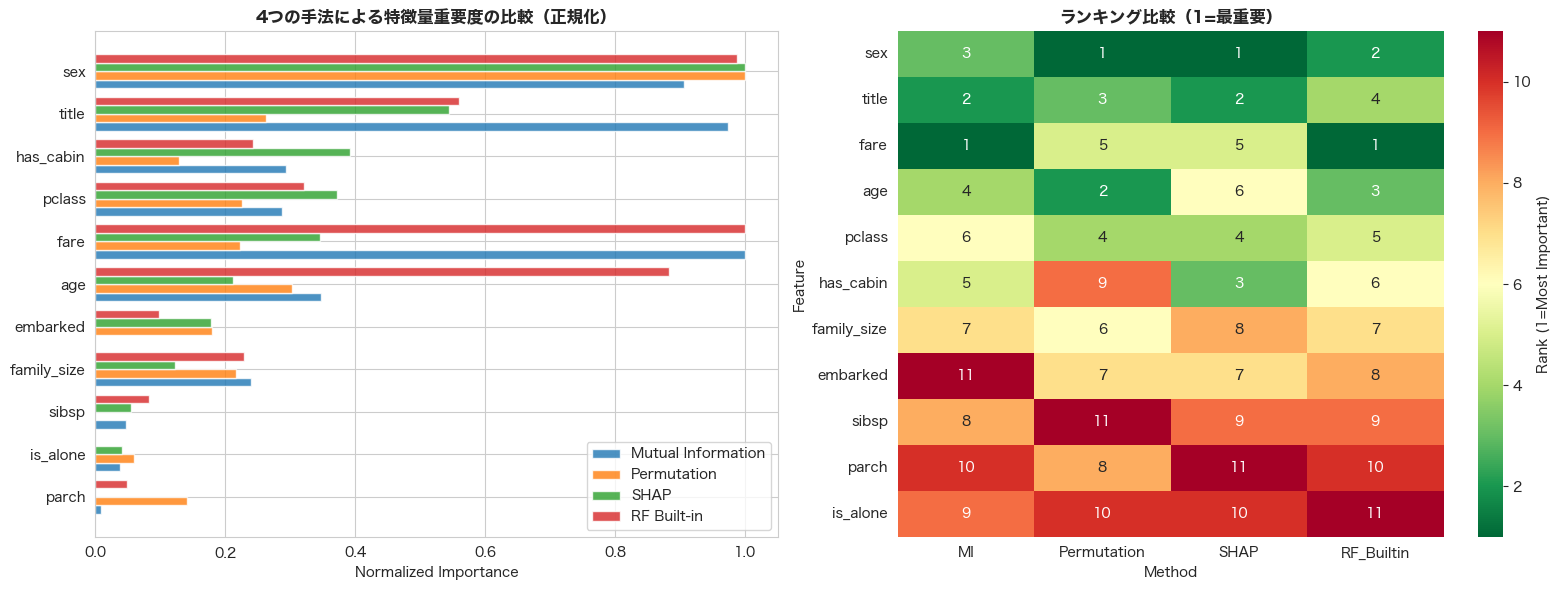

In [21]:
# ============================================================
# 可視化: レーダーチャートで比較
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 棒グラフで比較
ax1 = axes[0]
x = np.arange(len(feature_cols))
width = 0.2

# 正規化した値でプロット
comparison_sorted = comparison_df.sort_values('SHAP_norm', ascending=True)
features_sorted = comparison_sorted['Feature'].values

ax1.barh(x - 1.5*width, comparison_sorted['MI_norm'], width, label='Mutual Information', alpha=0.8)
ax1.barh(x - 0.5*width, comparison_sorted['Permutation_norm'], width, label='Permutation', alpha=0.8)
ax1.barh(x + 0.5*width, comparison_sorted['SHAP_norm'], width, label='SHAP', alpha=0.8)
ax1.barh(x + 1.5*width, comparison_sorted['RF_Builtin_norm'], width, label='RF Built-in', alpha=0.8)

ax1.set_yticks(x)
ax1.set_yticklabels(features_sorted)
ax1.set_xlabel('Normalized Importance')
ax1.set_title('4つの手法による特徴量重要度の比較（正規化）', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')

# ランキングのヒートマップ
ax2 = axes[1]
rank_matrix = comparison_df.set_index('Feature')[['MI_rank', 'Permutation_rank', 'SHAP_rank', 'RF_Builtin_rank']]
rank_matrix.columns = ['MI', 'Permutation', 'SHAP', 'RF_Builtin']

# 平均ランクでソート
rank_matrix['Avg'] = rank_matrix.mean(axis=1)
rank_matrix = rank_matrix.sort_values('Avg').drop('Avg', axis=1)

sns.heatmap(rank_matrix, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            ax=ax2, cbar_kws={'label': 'Rank (1=Most Important)'})
ax2.set_title('ランキング比較（1=最重要）', fontsize=12, fontweight='bold')
ax2.set_xlabel('Method')

plt.tight_layout()
plt.show()

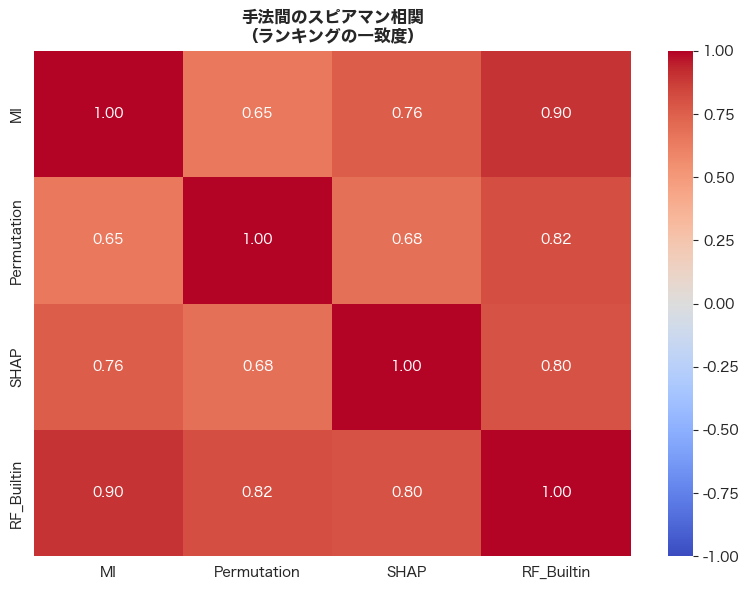


相関の解釈:
- 高い相関: 両手法が同じ特徴量を重要と判断
- 低い相関: 各手法が異なる「重要度」を測定している証拠

観察:
- SHAP と RF_Builtin は高相関（ツリーベースの性質が反映）
- MI は他の手法と相関がやや低い（モデル非依存のため）


In [22]:
# ============================================================
# 手法間の相関分析
# ============================================================

fig, ax = plt.subplots(figsize=(8, 6))

# 重要度の相関行列
importance_corr = comparison_df[['MI', 'Permutation', 'SHAP', 'RF_Builtin']].corr(method='spearman')

sns.heatmap(importance_corr, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, ax=ax, vmin=-1, vmax=1)
ax.set_title('手法間のスピアマン相関\n（ランキングの一致度）', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n相関の解釈:")
print("- 高い相関: 両手法が同じ特徴量を重要と判断")
print("- 低い相関: 各手法が異なる「重要度」を測定している証拠")
print("\n観察:")
print("- SHAP と RF_Builtin は高相関（ツリーベースの性質が反映）")
print("- MI は他の手法と相関がやや低い（モデル非依存のため）")

---

## Part 7: 結果の解釈と実践的ガイドライン

### 各手法の結果まとめ

In [23]:
# ============================================================
# 結果のサマリー
# ============================================================

print("="*80)
print("特徴量重要度分析のサマリー")
print("="*80)

print("\n【全手法で一貫して重要な特徴量】")
print("-" * 40)
consistent_important = rank_df[rank_df['Avg_Rank'] <= 3]['Feature'].tolist()
for feat in consistent_important:
    print(f"  ✓ {feat}")

print("\n【手法によって評価が分かれる特徴量】")
print("-" * 40)
# ランクの標準偏差が大きい特徴量
rank_df_temp = comparison_df[['Feature', 'MI_rank', 'Permutation_rank', 'SHAP_rank', 'RF_Builtin_rank']].copy()
rank_df_temp['Rank_Std'] = rank_df_temp[['MI_rank', 'Permutation_rank', 'SHAP_rank', 'RF_Builtin_rank']].std(axis=1)
variable_features = rank_df_temp.nlargest(3, 'Rank_Std')
for _, row in variable_features.iterrows():
    print(f"  ? {row['Feature']} (Rank std: {row['Rank_Std']:.1f})")

print("\n【各手法が測定しているもの】")
print("-" * 40)
print("  MI: データ自体に含まれる情報量（モデル前）")
print("  Permutation: モデルがその情報にどれだけ依存しているか")
print("  SHAP: 予測値への実際の貢献度")
print("  RF_Builtin: 分割に使われた頻度と効果")

特徴量重要度分析のサマリー

【全手法で一貫して重要な特徴量】
----------------------------------------
  ✓ sex
  ✓ title
  ✓ fare

【手法によって評価が分かれる特徴量】
----------------------------------------
  ? has_cabin (Rank std: 2.5)
  ? fare (Rank std: 2.3)
  ? embarked (Rank std: 1.9)

【各手法が測定しているもの】
----------------------------------------
  MI: データ自体に含まれる情報量（モデル前）
  Permutation: モデルがその情報にどれだけ依存しているか
  SHAP: 予測値への実際の貢献度
  RF_Builtin: 分割に使われた頻度と効果


### 実践的ガイドライン

#### どの手法をいつ使うか？

| 目的 | 推奨手法 | 理由 |
|------|----------|------|
| **特徴量選択（モデル構築前）** | 相互情報量 (MI) | モデルに依存しない、計算が高速 |
| **モデル診断・過学習検出** | Permutation Importance | Train vs Test の比較が可能 |
| **個別予測の説明（非技術者向け）** | LIME | 線形で理解しやすい |
| **個別予測の説明（正確性重視）** | SHAP | 理論的に公平、一貫性がある |
| **グローバルな特徴量理解** | SHAP | Summary plot、Dependence plot |
| **規制対応・説明責任** | SHAP | 数学的根拠がある |

#### 複数手法を組み合わせるメリット

1. **モデルバイアスの検出**: MIでは重要だがモデルでは使われていない特徴量を発見
2. **ロバスト性の確認**: 複数手法で一貫して重要な特徴量は信頼度が高い
3. **異なる視点**: グローバル（SHAP）とローカル（LIME）の両方を理解

In [24]:
# ============================================================
# タイタニック分析の最終的な洞察
# ============================================================

print("="*80)
print("タイタニック生存予測: 特徴量重要度からの洞察")
print("="*80)

insights = {
    'sex': {
        'finding': '全手法で最重要',
        'interpretation': '「女性と子供を優先」の救助方針が明確に反映',
        'action': 'モデルの核心的な予測因子'
    },
    'pclass': {
        'finding': '全手法で上位',
        'interpretation': '上級客室は救命ボートに近く、社会的にも優先された',
        'action': '社会的階層と生存の関係を示す重要な変数'
    },
    'title': {
        'finding': 'MIで特に高い',
        'interpretation': '性別+年齢+婚姻状態の複合情報を含む',
        'action': '特徴量エンジニアリングの有効性を示す'
    },
    'fare': {
        'finding': 'SHAPとRFで重要',
        'interpretation': 'pclassと相関が高いが、より細かい経済状況を反映',
        'action': 'pclassとの多重共線性に注意'
    },
    'age': {
        'finding': '手法により評価が異なる',
        'interpretation': '子供は優先されたが、若い成人 vs 高齢者の差は小さい',
        'action': 'カテゴリ化（Child/Adult）が有効かもしれない'
    },
    'family_size': {
        'finding': 'Permutationで過小評価',
        'interpretation': 'sibsp/parchと相関が高いため重要度が分散',
        'action': '単独で使うか、sibsp/parchを削除するか選択'
    }
}

for feature, info in insights.items():
    print(f"\n【{feature}】")
    print(f"  発見: {info['finding']}")
    print(f"  解釈: {info['interpretation']}")
    print(f"  示唆: {info['action']}")

タイタニック生存予測: 特徴量重要度からの洞察

【sex】
  発見: 全手法で最重要
  解釈: 「女性と子供を優先」の救助方針が明確に反映
  示唆: モデルの核心的な予測因子

【pclass】
  発見: 全手法で上位
  解釈: 上級客室は救命ボートに近く、社会的にも優先された
  示唆: 社会的階層と生存の関係を示す重要な変数

【title】
  発見: MIで特に高い
  解釈: 性別+年齢+婚姻状態の複合情報を含む
  示唆: 特徴量エンジニアリングの有効性を示す

【fare】
  発見: SHAPとRFで重要
  解釈: pclassと相関が高いが、より細かい経済状況を反映
  示唆: pclassとの多重共線性に注意

【age】
  発見: 手法により評価が異なる
  解釈: 子供は優先されたが、若い成人 vs 高齢者の差は小さい
  示唆: カテゴリ化（Child/Adult）が有効かもしれない

【family_size】
  発見: Permutationで過小評価
  解釈: sibsp/parchと相関が高いため重要度が分散
  示唆: 単独で使うか、sibsp/parchを削除するか選択


---

## Summary

### 学んだこと

1. **相互情報量 (MI)**
   - データ自体の統計的依存関係を測定
   - モデル非依存、特徴量選択に有用
   - 限界: 特徴量間の相互作用を考慮しない

2. **Permutation Importance**
   - モデルがその情報にどれだけ依存しているかを測定
   - Train vs Test で過学習を検出可能
   - 限界: 相関の高い特徴量で重要度が分散

3. **LIME**
   - 個別予測を局所的な線形モデルで説明
   - 人間が理解しやすい形式
   - 限界: 安定性が低い、グローバルな理解には不向き

4. **SHAP**
   - ゲーム理論に基づく公平な貢献度計算
   - グローバル＆ローカル両方の解釈が可能
   - 限界: 計算コストが高い

### 重要なポイント

- **「重要度」の意味は手法によって異なる** → 目的に応じて選択
- **複数手法を組み合わせる** → より堅牢な理解が得られる
- **モデルバイアスを排除** → データの本質的な構造に迫れる

### 次のステップ

- Notebook 22: Stacking Ensemble でさらなる精度向上
- 実際のKaggleコンペで特徴量重要度分析を実践
- より高度な手法（Integrated Gradients, Attention Weights）を探求

---

## 🎓 自己評価クイズ

### Q1: 相互情報量とPermutation Importanceの結果が大きく異なる場合、何を示唆していますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: モデルがデータに含まれる情報を十分に活用していない可能性がある

- MI が高いのに Permutation が低い → その特徴量には予測に有用な情報があるが、モデルが使っていない
- 原因: 他の相関する特徴量で代替されている、モデルの表現力不足、過学習対策で無視されている等
- 対策: モデルの変更、特徴量エンジニアリング、相関分析

</details>

---

### Q2: LIMEとSHAPのどちらを使うべきか、どのように判断しますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 目的と対象者に応じて選択

- **LIME を選ぶケース**:
  - 非技術者への説明（シンプルな線形の説明が欲しい）
  - 計算リソースが限られている
  - 「この予測の主な理由」をざっくり知りたい

- **SHAP を選ぶケース**:
  - 厳密な数学的根拠が必要（規制対応など）
  - グローバルな傾向も理解したい
  - 一貫性のある説明が必要
  - 特徴量間の相互作用を分析したい

</details>

---

### Q3: 相関の高い特徴量がある場合、Permutation Importance にどのような影響がありますか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 重要度が過小評価される（分散する）

- 例: `sibsp` と `family_size` が高相関の場合
- `sibsp` をシャッフルしても、`family_size` から似た情報が得られる
- 結果: 両方の重要度が本来より低く出る

- **対策**:
  1. 相関の高い特徴量の一方を削除
  2. グループごとにまとめてシャッフル
  3. SHAPなど他の手法と併用して確認

</details>